# Data Generation - Synthetic Data on Real Contact Graph
ref: http://www.sociopatterns.org/datasets/primary-school-temporal-network-data/

In [ ]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('/root/Deep_demixing/')
from utils import draw_epidemic_network, load_dataset, COO_to_matrix, matrix_to_COO


import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import copy
import torch



In [2]:
# Returns the number of infected neighbors of a given node

def count_infected_neighbors(G, node, node_values):

    counter = 0
    neighbors_dict = G.neighbors(node)
    
    for neighbor in neighbors_dict:
        if node_values[neighbor] == 1:
            counter += 1
    
    return counter

In [3]:
def SIRS_spreading(G, starting_node, betas, deltas, betas_recovered, N_steps, N_second = None, show_plots = True, show_aggregated = True, plot_actives = False, with_labels = True, layout = "shell", plot_timesteps = [], figsize = (6, 6), node_size = 80, average_agg = True):

    beta, delta, beta_recovered = betas[0], deltas[0], betas_recovered[0]
    if (not N_second == None):
        beta_1, delta_1, beta_recovered_1 = betas[1], deltas[1], betas_recovered[1]

    # All node values at a certain time step will be stored in a dictionary called node_values
    # Initialize the value of the first infected node to 1
    node_values = {starting_node : 1}
    recovered_dict = {}

    # Initialize all the rest to 0
    for node in G.nodes():
        recovered_dict.update({node : 0})
        if node != starting_node:
            node_values.update({node : 0})

    # Store all node_values 
    all_node_values = [copy.copy(node_values)]
    
    # Initialize the aggregated signal
    aggregated = copy.copy(node_values)

    # Store the total number of infected nodes at every time step
    active_infected = [1]
    
    timestep = 0
    # Run the simulation N_steps times: 
    while (timestep < N_steps - 1):

        if (not N_second == None) and (timestep > N_second):
            beta = beta_1
            delta = delta_1 
            beta_recovered = beta_recovered_1

        # Plot the current graph
        if (show_plots == True) or (timestep in plot_timesteps):
            print("Timestep " + str(timestep) + ":")
            draw_epidemic_network(G, node_values, layout=layout, with_labels=with_labels, figsize=figsize, node_size=node_size)

        # For every susceptible node, flip the coin for every of its infected neighbors (generate a random value)
        # => if at least one value is grater than beta, the current node is considered infected, starting next time step

        # For every infected node, flip the coin => it becomes susceptible with probability delta
        next_values = {}
        current_active = 0

        for node in G.nodes():

            # If the node is susceptible:
            if node_values[node] == 0:

                infected_neighbors = count_infected_neighbors(G, node, node_values)
                # Now we flip the coin for every infected neighbour:
                infected = False 

                for i in range(0, infected_neighbors):
                    random_value = np.random.rand()
                    if random_value < beta:
                        infected = True 
                        break 
                    
                if infected == True:
                    next_values.update({node : 1})
                    aggregated[node] += 1
                else: 
                    next_values.update({node : 0})


            # If the node is recovered:
            if (node_values[node] == 0) and (recovered_dict[node] == 1):

                infected_neighbors = count_infected_neighbors(G, node, node_values)
                # Now we flip the coin for every infected neighbour:
                susceptible = False 

                for i in range(0, infected_neighbors):
                    random_value = np.random.rand()
                    if random_value < beta_recovered:
                        susceptible = True 
                        break 
                
                next_values.update({node : 0})
                    
                if susceptible == True:
                    recovered_dict[node] = 0


            # If the node is infected:
            if node_values[node] == 1:

                current_active += 1

                # Flip the coin:
                recovered = False 

                random_value = np.random.rand()
                if random_value < delta:
                    recovered = True
                
                if recovered == True:
                    next_values.update({node : 0})
                    recovered_dict[node] = 1
                else: 
                    next_values.update({node : 1})
                    aggregated[node] += 1

        # Update node_values for next time step and reset next_values
        node_values = copy.copy(next_values)
        next_values = {}
        all_node_values.append(copy.copy(node_values))

        active_infected.append(current_active)
        timestep += 1


    # Plot the final graph, corresponding to the final node_values
    if (show_plots == True) or (N_steps in plot_timesteps):
        print("Final graph:")
        draw_epidemic_network(G, node_values, layout = layout, with_labels = with_labels, figsize = figsize, node_size=node_size)    
    
    # Divide the aggregated signal by the number of time steps 
    aggregated_avg = {}

    if (average_agg == True):
        for node in G.nodes():
            aggregated_avg.update({node : np.round((aggregated[node] / N_steps), 2)})
    else:
        # Aggregated signal = last day of the pandemic
        aggregated_avg = copy.deepcopy(all_node_values[-1])


    # Plot the final graph with aggregated values of nodes set as labels
    if (show_aggregated == True):
        print("Final graph with the aggregated values at each node:")
        draw_epidemic_network(G, node_values, labels = aggregated_avg, figsize=figsize, layout = layout, node_size=node_size)

    # Plot the function of active cases
    if (plot_actives == True):
        time_axis = np.arange(0, N_steps)
        plt.plot(time_axis, active_infected)
        plt.xlabel('Time')
        plt.ylabel('Number of infected nodes')
        plt.title('Number of actively infected nodes through time')
        plt.ylim([0, G.number_of_nodes()])
        plt.grid()
        plt.show()


    return [all_node_values, aggregated_avg]


# Generating a dataset

In [4]:
import networkx as nx 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

"""
primaryschool.csv - Each line has the form t i j Ci Cj, 
where i and j are the anonymous IDs of the persons in contact, 
Ci and Cj are their classes, and the interval during which this contact was active is [t − 20s, t], 
where the time t is measured in seconds. If multiple contacts are active in a given interval, 
you will see multiple lines starting with the same value of t.

metadata_primaryschool.txt - contains information about the class and gender of all the people involved.
"""
g_data = pd.read_csv('./primaryschool.csv',sep='\t',header=None)
g_data.columns=['t', 'i', 'j', 'Ci', 'Cj']

exclude = ['Teachers']#'1A','1B', '5A','5B','Teachers']
g_data = g_data[~g_data.Ci.isin(exclude)]
g_data = g_data[~g_data.Cj.isin(exclude)]


# NOTE: I WAS WRONG CALLING THIS MORNING / AFTERNOON. these were actually 2 separate days.
tm_noon = 90000
gData = {'M':g_data.loc[g_data.t<90000], 
      'A':g_data.loc[g_data.t>90000]}

G = {k:nx.Graph() for k in gData.keys()}


# ---- morning/afternoon contact graph ----

for g_key in gData.keys():

    id_set = sorted(np.unique(gData[g_key][['i','j']]))
    id_dict = {id_o:i for i, id_o in enumerate(id_set)}

    for r in tqdm(range(len(gData[g_key]))):

        pers = gData[g_key].iloc[r]
        i = id_dict[pers.i]
        j = id_dict[pers.j]

        # add contacts
        G[g_key].add_node(i,cls=pers.Ci) 
        G[g_key].add_node(j,cls=pers.Cj)  

        # increment edge
        try:
            G[g_key][i][j]['weight'] += 1 
        except:
            G[g_key].add_edge(i, j, weight=1) 



M 226


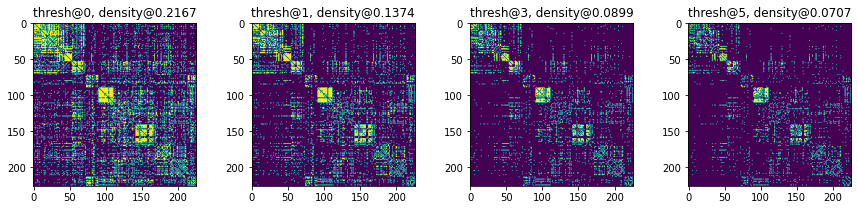

A 228


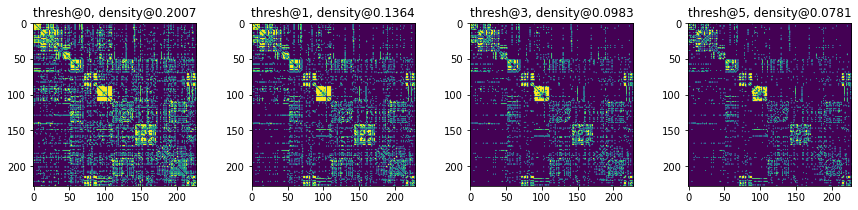

In [5]:
G_new = {}

for gk, gv in G.items():
    
    print(gk, len(gv))

    A = nx.to_numpy_matrix(gv, nodelist=sorted(gv.nodes()))
#     plt.hist(A[A>0].T, bins=500)
#     plt.xscale('log')
#     plt.show()

    plt.figure(figsize=(15,3))

    for ii, athresh in enumerate([0,1,3,5]):
        plt.subplot(141+ii)
        AA = (A > athresh).astype(np.int_) 

        # make connected
        zeroed = np.where(np.sum(AA,-1)==0)[0]
        AA[zeroed] = (A[zeroed]>0).astype(np.int_) 

        plt.imshow(AA)
        plt.title('thresh@%d, density@%.4f'%(athresh, np.sum(AA)/AA.shape[0]**2))
    
    plt.show()

    graph = nx.from_numpy_matrix(AA)
    nx.set_node_attributes(graph, nx.spring_layout(gv, 1/3.), "pos")
    nx.set_node_attributes(graph, nx.get_node_attributes(gv,"cls"), "cls")
    
    G_new[gk] = graph



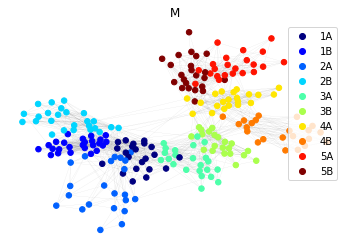

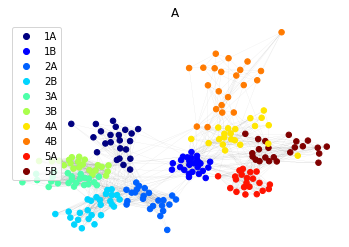

In [6]:

for gk, gv in G_new.items():
    # make a map from 'Class' to colors
    nodes = gv.nodes()
    groups = set(nx.get_node_attributes(gv,'cls').values()) # get unique groups
    color_map = {cla: i / (len(groups)-1) for i, cla in enumerate(sorted(groups))}
    colors = [color_map[gv.nodes[n]['cls']] for n in nodes]


    # spring layout
    pos = nx.get_node_attributes(gv,"pos")

    fig, ax = plt.subplots()

    # drawing nodes and edges separately so we can capture collection for colobar
    ec = nx.draw_networkx_edges(gv, pos, alpha=0.5,width=.05, edge_color='black')
    nc = nx.draw_networkx_nodes(gv, pos, node_color=colors, node_size=30, cmap=plt.cm.jet)

    # Generate artificial points to create the legend
    for cla, cc in color_map.items():
        plt.plot([], [],'o', color=plt.cm.jet(cc), label=cla)
        
    plt.title(gk)
    plt.legend() 
    plt.axis('off')
    plt.show()

## One source

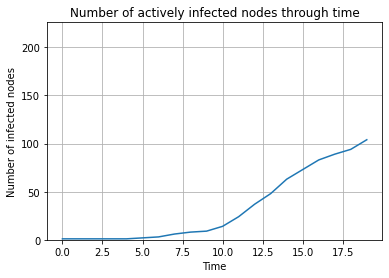

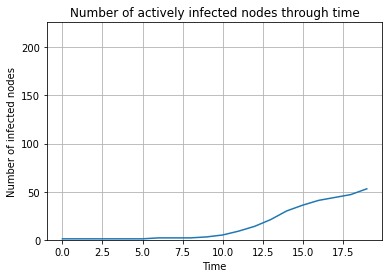

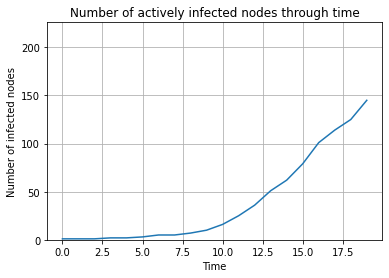

In [7]:
# !!! If you want to simulate two waves of the pandemic, N_second is the timestep at which the rates become infection_rates[1], curation_rates[1], recovered_infection_rates[1]

# If you only want one pandemic wave, then it should be N_second = None, rates will be infection_rates[0], curation_rates[0], recovered_infection_rates[0] and the rates at index [1] will be ignored

g_key = 'M'#'A'
graph = G_new[g_key]
node_number = len(graph)

# Hyperparameters:
infection_rates = np.array([0.6, 0.7])*.07
curation_rates = np.array([0.2, 0.2])*.08
recovered_infection_rates = np.array([0.01, 0.1])*.08

N_timesteps = 20
N_simulations = 3

# data - list of lists [all_values_i, aggregated_i]
# all_values_i : node_number x N_timesteps
# aggregated_i : node_number x 1
data = []
for sim in tqdm(range(0, N_simulations)):
    
#     print(starting_node, N_second)

    starting_node, N_second = np.random.randint(node_number, size=2)
    
    final_values = SIRS_spreading(graph, starting_node, infection_rates, curation_rates, recovered_infection_rates, N_timesteps, N_second,
                                show_plots = False, plot_actives = True, show_aggregated = False, average_agg = False, layout = "geometric")

    # Current simulation signals -> matrices:
    all_values = final_values[0]
    aggregated = final_values[1]

    data_aggregated = np.zeros((node_number, 1))
    data_uncollapsed = np.zeros((node_number, N_timesteps))

    for node in range(0, node_number):
        data_aggregated[node] = aggregated[node]

        for step in range(0, N_timesteps):
            data_uncollapsed[node][step] = all_values[step][node]

    data.append([data_uncollapsed, data_aggregated])

adj = nx.to_numpy_matrix(graph)
node_attributes = nx.get_node_attributes(graph, "pos")
node_class = nx.get_node_attributes(graph,"cls")

dataset = {'adj' : adj, 'data' : data, 'attr' : node_attributes, 'cls': node_class}

# save the dataset

In [8]:
# import pickle 
# ex_str = ''.join(sorted(set([ex[0] for ex in exclude])))

# # os.makedirs("../datasets/exp_10/20_steps/")
# filehandler = open("../datasets/exp_10/20_steps/REAL_wCLS_%s_Excl%s_%dedgethresh_%dnodes_%dsteps_%dsims.obj"%(
#     g_key, ex_str, athresh, node_number, N_timesteps, N_simulations), 'wb')

# pickle.dump(dataset, filehandler)

# filehandler.close()

## display an example

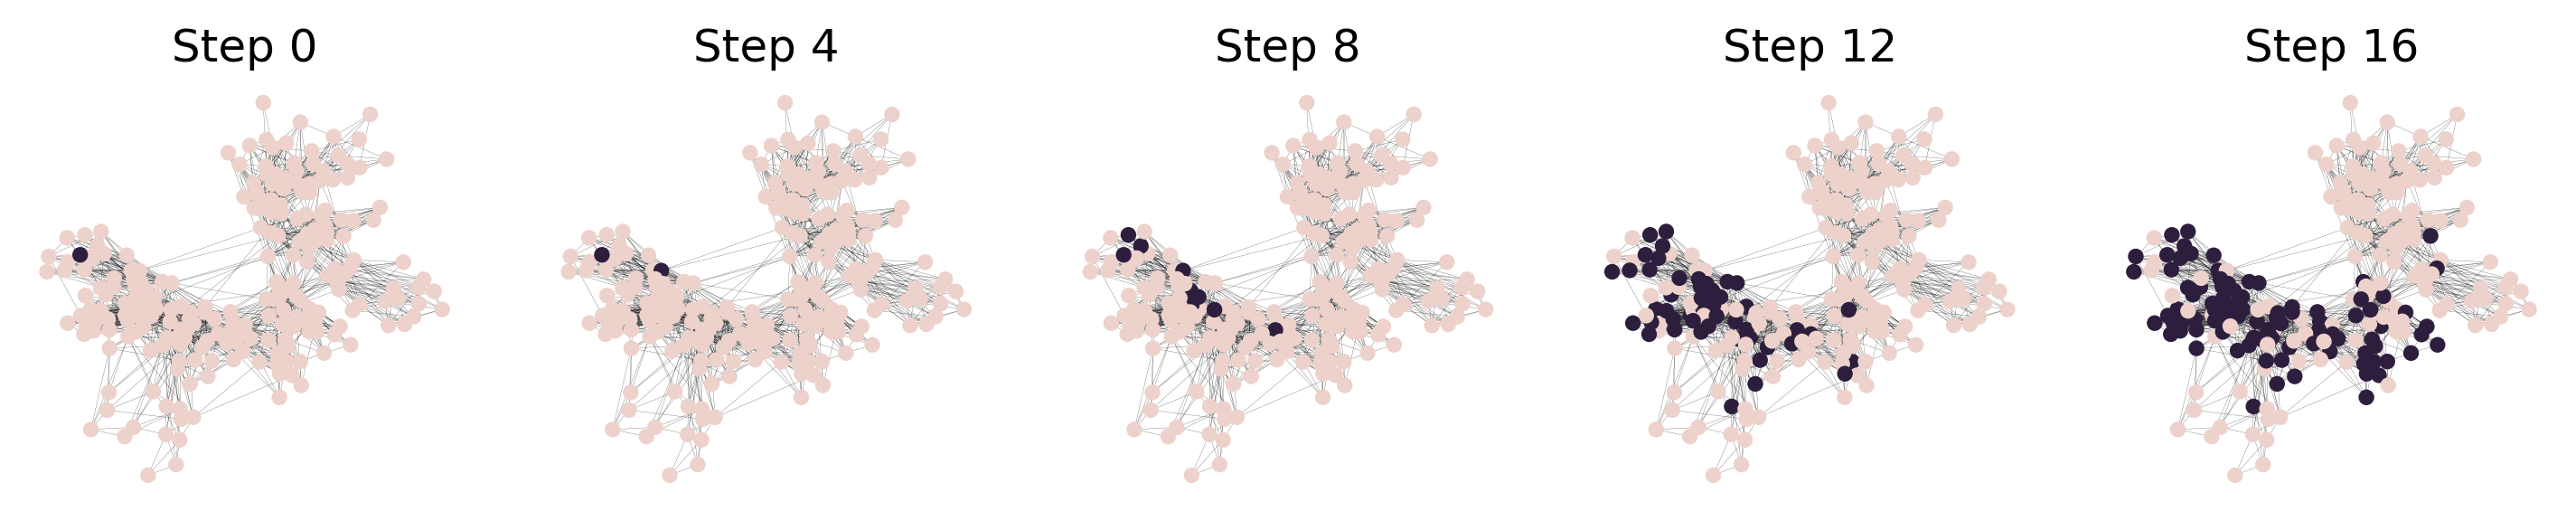

In [9]:
import seaborn as sns

cmap = sns.cubehelix_palette(as_cmap=True)

kk=0
nn=0

to_plot = list(range(20))[::4]

plt.figure(figsize=(12,2), dpi=300)

for day in range(data[kk][0].shape[-1]):
    if day not in to_plot:
        continue
        
    plt.subplot(int('1%d%d'%(len(to_plot), (nn+1))))

    color_map = []
    for i,_ in enumerate(graph):
        color_map.append(cmap(data[kk][0][i,day]))

    nx.draw(graph, pos=node_attributes, 
            node_color=color_map, node_size=10, width=.05)
    
    plt.title('Step %d'%day)
#     plt.show()

    nn+=1